In [66]:
import logging
import os
import random
from collections import Counter

import numpy as np
import scanpy as sc

import pollock
from pollock.models.model import PollockDataset, PollockModel
import pollock.models.analysis as pollock_analysis

In [18]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## load in dataset


In [171]:
adata = sc.read_loom('/Users/erikstorrs/Documents/ding/imaging/data/htan/single_cell/TWCE-HT061P1-S1PAA1A1Z1B1_processed_annotated.loom')
adata

/Users/erikstorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/loompy/loom_layer.py:123: RuntimeWarning: invalid value encountered in not_equal
  nonzeros = np.where(vals != 0)


AnnData object with n_obs × n_vars = 2131 × 19532 
    obs: 'ClusterID', 'ClusterName', 'SCT_snn_res_0_5', 'cell_type', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'orig_ident', 'percent_mito', 'seurat_clusters'
    var: 'Selected', 'detection_rate', 'gmean', 'residual_mean', 'residual_variance', 'variance'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [176]:
## get rid of unknown
adata = adata[adata.obs['ClusterName']!='Unknown', :]
adata

View of AnnData object with n_obs × n_vars = 1991 × 19532 
    obs: 'ClusterID', 'ClusterName', 'SCT_snn_res_0_5', 'cell_type', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'orig_ident', 'percent_mito', 'seurat_clusters'
    var: 'Selected', 'detection_rate', 'gmean', 'residual_mean', 'residual_variance', 'variance'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [127]:
# ## subsample for testing purposes
# idxs = random.sample(list(range(adata.shape[0])), k=1000)
# adata = adata[idxs, :]
# adata

View of AnnData object with n_obs × n_vars = 1000 × 19532 
    obs: 'ClusterID', 'ClusterName', 'SCT_snn_res_0_5', 'cell_type', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'orig_ident', 'percent_mito', 'seurat_clusters'
    var: 'Selected', 'detection_rate', 'gmean', 'residual_mean', 'residual_variance', 'variance'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [177]:
c = Counter(adata.obs['ClusterName'])
c.most_common()

[('Ductal', 430),
 ('CD4_T', 361),
 ('Fibroblast', 285),
 ('CD8_T', 245),
 ('Macrophage', 146),
 ('Endothelial', 145),
 ('Mast', 117),
 ('Acinar', 108),
 ('NK', 67),
 ('Treg', 45),
 ('B', 21),
 ('Plasma', 21)]

In [175]:
import pollock.preprocessing.preprocessing as pp
list(pp.listfiles(os.getcwd(), regex=r'\.tfcache'))

['/Users/erikstorrs/Documents/ding/pollock/notebooks/validation.tfcache.index',
 '/Users/erikstorrs/Documents/ding/pollock/notebooks/training.tfcache.index',
 '/Users/erikstorrs/Documents/ding/pollock/notebooks/training.tfcache.data-00000-of-00001',
 '/Users/erikstorrs/Documents/ding/pollock/notebooks/validation.tfcache.data-00000-of-00001']

## train with pollock

In [178]:
%autoreload 2

pollock_dataset = PollockDataset(adata, dataset_type='training',
                                image_root_dir=os.path.join(os.getcwd(), 'test_training'),
                                n_per_cell_type=500, max_val_per_cell_type=500)

/Users/erikstorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/anndata/_core/anndata.py:1172: ImplicitModificationWarning: Initializing view as actual.
  "Initializing view as actual.", ImplicitModificationWarning
Trying to set attribute `.obs` of view, copying.
... storing 'ClusterName' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'SCT_snn_res_0_5' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'cell_type' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'orig_ident' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'seurat_clusters' as categorical
/Users/erikstorrs/miniconda3/envs/pollock_v2/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:237: RuntimeWarning: overflow encountered in expm1
  foldchanges = (expm1_func(mean_group) + 1e-9) / (expm1_func(mean_rest) + 1e-9)  # add small value to remove 0's


array([[6, 6, 6, ..., 2, 2, 2],
       [6, 6, 6, ..., 2, 2, 2],
       [6, 6, 6, ..., 2, 2, 2],
       ...,
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

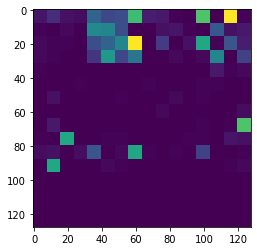

In [179]:
cell_id = adata.obs.index[0]
pollock_dataset.get_cell_image(cell_id)

In [180]:
pollock_dataset.cell_types

['Acinar',
 'B',
 'CD4_T',
 'CD8_T',
 'Ductal',
 'Endothelial',
 'Fibroblast',
 'Macrophage',
 'Mast',
 'NK',
 'Plasma',
 'Treg']

In [181]:
x, y = next(iter(pollock_dataset.train_ds))
x.shape, y.shape

(TensorShape([64, 128, 128, 3]), TensorShape([64, 12]))

In [182]:
model = PollockModel(pollock_dataset.cell_types)

In [183]:
model.fit(pollock_dataset)

Train for 94 steps, validate for 7 steps
Epoch 1/10
94/94 [==============================] - 31s 327ms/step - loss: 0.2964 - accuracy: 0.8983 - val_loss: 0.2523 - val_accuracy: 0.9040
Epoch 2/10
94/94 [==============================] - 28s 302ms/step - loss: 0.0865 - accuracy: 0.9701 - val_loss: 0.1746 - val_accuracy: 0.9464
Epoch 3/10
94/94 [==============================] - 28s 301ms/step - loss: 0.0512 - accuracy: 0.9809 - val_loss: 0.1622 - val_accuracy: 0.9621
Epoch 4/10
94/94 [==============================] - 28s 296ms/step - loss: 0.0442 - accuracy: 0.9825 - val_loss: 0.1295 - val_accuracy: 0.9576
Epoch 5/10
94/94 [==============================] - 28s 294ms/step - loss: 0.0306 - accuracy: 0.9895 - val_loss: 0.1663 - val_accuracy: 0.9576
Epoch 6/10
94/94 [==============================] - 28s 295ms/step - loss: 0.0193 - accuracy: 0.9930 - val_loss: 0.2024 - val_accuracy: 0.9554


In [184]:
prediction_dataset = PollockDataset(adata, dataset_type='prediction',
                                   image_root_dir=os.path.join(os.getcwd(), 'test_prediction'),
                                   gene_template=pollock_dataset.gene_template,
                                   cell_type_template=pollock_dataset.cell_type_template,
                                   cell_types=pollock_dataset.cell_types,
                                   batch_size=64)

Found 1991 images belonging to 1 classes.


In [185]:
probs = model.predict(prediction_dataset)
probs.shape

(1991, 12)

In [186]:
predictions = np.argmax(probs, axis=1).flatten()
predicted_labels = [prediction_dataset.cell_types[i] for i in predictions]
len(predictions), predictions[:5]

(1991, array([2, 4, 6, 4, 2]))

In [187]:
len(set(prediction_dataset.cell_ids))

1991

In [188]:
cell_type_to_index = {v:k for k, v in enumerate(prediction_dataset.cell_types)}
groundtruth = [cell_type_to_index[cell_type]
               for cell_type in adata[prediction_dataset.cell_ids, :].obs['cell_type']]
len(groundtruth), groundtruth[:5]

(1991, [2, 4, 6, 4, 2])

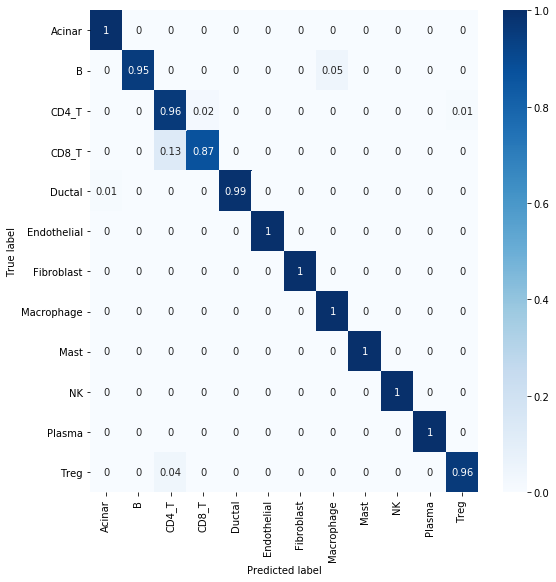

In [189]:
c_df = pollock_analysis.get_confusion_matrix(predictions, groundtruth, prediction_dataset.cell_types)

In [197]:
embedding = pollock_analysis.umap_final_layer(prediction_dataset.prediction_ds, model.model)
embedding.shape

(1991, 2)

In [192]:
adata

AnnData object with n_obs × n_vars = 1991 × 19532 
    obs: 'ClusterID', 'ClusterName', 'SCT_snn_res_0_5', 'cell_type', 'nCount_RNA', 'nCount_SCT', 'nFeature_RNA', 'nFeature_SCT', 'orig_ident', 'percent_mito', 'seurat_clusters'
    var: 'Selected', 'detection_rate', 'gmean', 'residual_mean', 'residual_variance', 'variance'
    uns: 'rank_genes_groups'
    obsm: 'pca_cell_embeddings', 'umap_cell_embeddings'
    varm: 'pca_feature_loadings'
    layers: 'norm_data', 'scale_data'

In [193]:
len(predicted_labels)

1991

... storing 'predicted_cell_type' as categorical


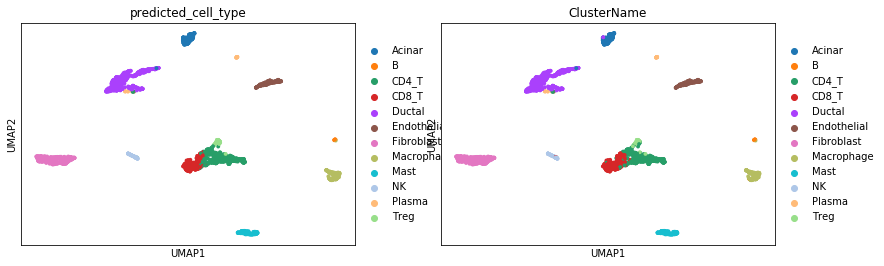

In [198]:
adata.obsm['X_umap'] = embedding
adata.obs['predicted_cell_type'] = predicted_labels
sc.pl.umap(adata, color=['predicted_cell_type', 'ClusterName'])

In [210]:
pollock_dataset.cell_types

['Acinar',
 'B',
 'CD4_T',
 'CD8_T',
 'Ductal',
 'Endothelial',
 'Fibroblast',
 'Macrophage',
 'Mast',
 'NK',
 'Plasma',
 'Treg']

In [206]:
x, y = next(iter(pollock_dataset.train_ds))
x.shape, y.shape

(TensorShape([64, 128, 128, 3]), TensorShape([64, 12]))

In [209]:
y_labels = np.asarray([prediction_dataset.cell_types[i] for i in np.argmax(y, axis=1).flatten()])
acinar_inputs = x[y_labels == 'Acinar']
acinar_inputs.shape

TensorShape([2, 128, 128, 3])

array([[10, 15, 21, ...,  3,  8,  2],
       [15, 18, 25, ...,  7, 12,  6],
       [ 9, 11, 10, ...,  6,  9,  8],
       ...,
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0],
       [ 0,  0,  0, ...,  0,  0,  0]], dtype=uint8)

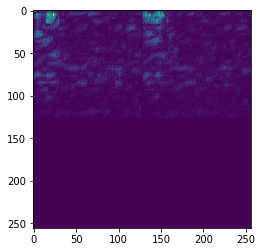

In [211]:
pollock_analysis.explain_predictions(model.model, acinar_inputs, 0)

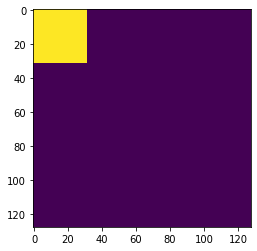

In [213]:
import matplotlib.pyplot as plt
plt.imshow(pollock_dataset.cell_type_template=='Acinar')